<ipython-input-32-5fdfec37cc6d>:7: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  variances = df.drop(columns=["Label"]).var()
<ipython-input-32-5fdfec37cc6d>:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x=feature_with_high_variance, hue="Label", common_norm=False, shade=True)


              Feature      Variance
44        Pkt_Len_Var  3.182113e+10
38         Fwd_Pkts/s  2.736553e+10
39         Bwd_Pkts/s  6.182269e+09
0            Src_Port  6.112092e+08
1            Dst_Port  3.077415e+08
68  Init_Bwd_Win_Byts  1.333721e+08
3       Flow_Duration  1.202725e+07
27        Bwd_IAT_Tot  9.859173e+06
77           Idle_Max  8.022507e+06
20       Flow_IAT_Max  8.021670e+06


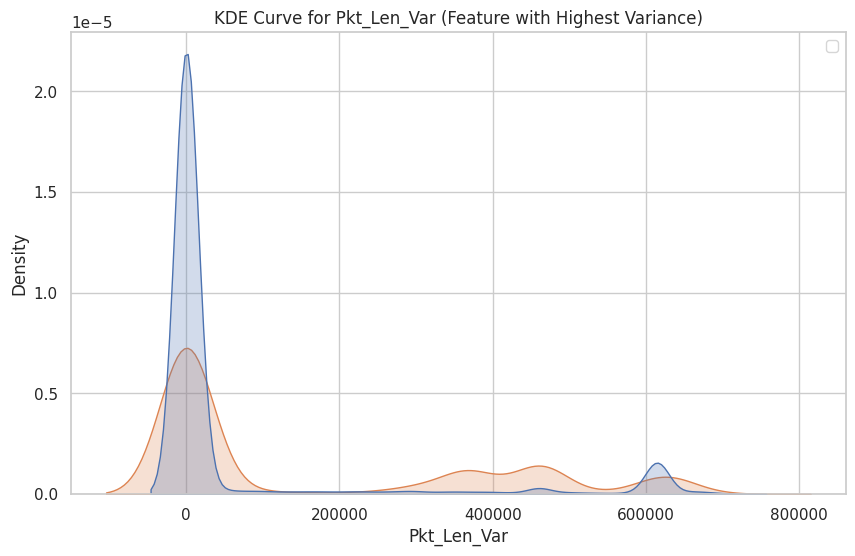

In [32]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/IoT Network Intrusion Dataset.csv")

variances = df.drop(columns=["Label"]).var()
variances_df = pd.DataFrame({'Feature': variances.index, 'Variance': variances.values})
variances_df = variances_df.sort_values(by='Variance', ascending=False).head(10)
print(variances_df)
feature_with_high_variance = variances.idxmax()

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.kdeplot(data=df, x=feature_with_high_variance, hue="Label", common_norm=False, shade=True)
plt.title(f"KDE Curve for {feature_with_high_variance} (Feature with Highest Variance)")
plt.xlabel(feature_with_high_variance)
plt.ylabel("Density")
plt.legend()
plt.show()


In [56]:
from river import ensemble
# from river import forest
from river import metrics
from river import stream
from river.drift import ADWIN
import pandas as pd

# Load your pandas DataFrame
df = pd.read_csv("/content/IoT Network Intrusion Dataset.csv")
df = df.sample(frac=0.01, random_state=42)

# Convert the pandas DataFrame to a river dataset
class PandasDataset:
    def __init__(self, df):
        self.df = df
        self.idx = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.idx >= len(self.df):
            raise StopIteration
        row = self.df.iloc[self.idx]
        self.idx += 1
        return row.drop("Label"), row["Label"]

dataset = PandasDataset(df)

# Choose an ensemble method
ensemble_model = ensemble.SRPClassifier()
# forest_model = forest.ARFClassifier()

# Define a parameter search space
param_space = {
    'n_models': [1, 10, 50]
}

# Implement online learning with ADWIN for drift detection
metric = metrics.Accuracy()
adwin = ADWIN()

for n_models in param_space['n_models']:
    ensemble_model = ensemble.SRPClassifier(n_models=n_models)
    # forest_model = forest.ARFClassifier()

    for x, y in dataset:
        y_pred = ensemble_model.predict_one(x)
        metric.update(y, y_pred)
        ensemble_model.learn_one(x, y)

        adwin.update(y_pred == y)  # Update ADWIN with the correct prediction

        # If ADWIN detects concept drift, restart the model
        if adwin.drift_detected:
            ensemble_model = ensemble.SRPClassifier(n_models=n_models)
            adwin.reset()

    score = metric.get()
    print(f'n_models: {n_models}, Accuracy: {score:.4f}')

print("Finished parameter search.")


/usr/local/lib/python3.10/dist-packages/river/stats/var.py:84: RuntimeWarning: invalid value encountered in double_scalars
  self._S += w * (x - mean_old) * (x - mean_new)
/usr/local/lib/python3.10/dist-packages/river/stats/mean.py:65: RuntimeWarning: invalid value encountered in double_scalars
  self._mean += (w / self.n) * (x - self._mean)
/usr/local/lib/python3.10/dist-packages/river/stats/var.py:84: RuntimeWarning: invalid value encountered in double_scalars
  self._S += w * (x - mean_old) * (x - mean_new)
/usr/local/lib/python3.10/dist-packages/river/proba/gaussian.py:74: RuntimeWarning: invalid value encountered in double_scalars
  return math.exp((x - self.mu) ** 2 / (-2 * var)) / math.sqrt(math.tau * var)
/usr/local/lib/python3.10/dist-packages/river/stats/mean.py:65: RuntimeWarning: invalid value encountered in double_scalars
  self._mean += (w / self.n) * (x - self._mean)


n_models: 1, Accuracy: 0.9939
n_models: 10, Accuracy: 0.9939
n_models: 50, Accuracy: 0.9939
Finished parameter search.


In [58]:
from river import forest


dataset = PandasDataset(df)

# Choose an ensemble method
forest_model = forest.ARFClassifier()

# Define a parameter search space
param_space = {
    'n_models': [10, 20, 30]
}

# Implement online learning with ADWIN for drift detection
metric = metrics.Accuracy()
adwin = ADWIN()

for n_models in param_space['n_models']:
    forest_model = forest.ARFClassifier(n_models=n_models)

    for x, y in dataset:
        y_pred = forest_model.predict_one(x)
        metric.update(y, y_pred)
        forest_model.learn_one(x, y)

        adwin.update(y_pred == y)  # Update ADWIN with the correct prediction

        # If ADWIN detects concept drift, restart the model
        if adwin.drift_detected:
            forest_model = forest.ARFClassifier(n_models=n_models)
            adwin.reset()

    score = metric.get()
    print(f'n_models: {n_models}, Accuracy: {score:.4f}')

print("Finished parameter search.")


/usr/local/lib/python3.10/dist-packages/river/stats/var.py:84: RuntimeWarning: invalid value encountered in double_scalars
  self._S += w * (x - mean_old) * (x - mean_new)
/usr/local/lib/python3.10/dist-packages/river/proba/gaussian.py:74: RuntimeWarning: invalid value encountered in double_scalars
  return math.exp((x - self.mu) ** 2 / (-2 * var)) / math.sqrt(math.tau * var)
/usr/local/lib/python3.10/dist-packages/river/stats/mean.py:65: RuntimeWarning: invalid value encountered in double_scalars
  self._mean += (w / self.n) * (x - self._mean)
/usr/local/lib/python3.10/dist-packages/river/stats/mean.py:65: RuntimeWarning: invalid value encountered in double_scalars
  self._mean += (w / self.n) * (x - self._mean)


n_models: 10, Accuracy: 0.9965
n_models: 20, Accuracy: 0.9965
n_models: 30, Accuracy: 0.9965
Finished parameter search.
